In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# from tqdm import tqdm


# Simulate Data

In [2]:
from epyfilter import simulate_data

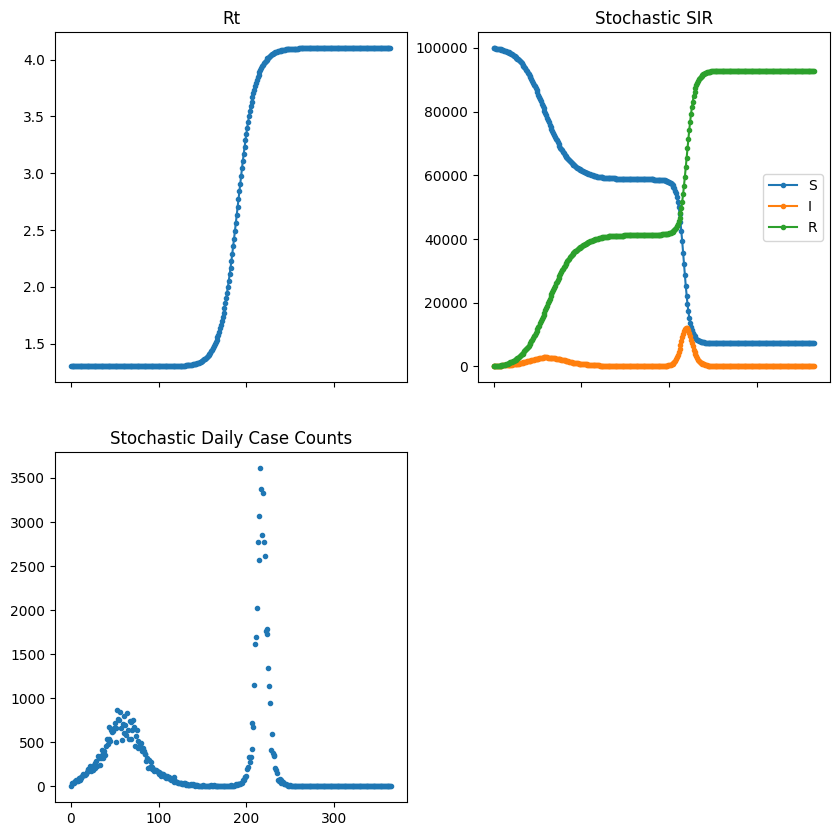

In [3]:
# true_params = {
#     'rt_0': 1.4,
#     'rt_1': 3.,
#     'midpoint': 100.,
#     'k': 0.1,
#     'n_t': 365,
#     't_I': 4.,
#     'N': 100_000.,
#     'S0': 99_900.,
#     'I0': 100.,
# }

true_params = {
    'rt_0': 1.3,
    'rt_1': 4.1,
    'midpoint': 190.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}

# true_params = {
#     'rt_0': 1.4,
#     'rt_1': 3.,
#     'midpoint': 100.,
#     'k': 0.1,
#     'n_t': 365,
#     't_I': 4.,
#     'N': 100_000.,
#     'S0': 99_900.,
#     'I0': 100.,
# }


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()
data.compute_data_distribution()

# Adaptive Inflation
Based on JL Anderson (2009)

In [5]:
from epyfilter import model_da

model = model_da.SIR_model(data)

Percent of observations in 95% CI 87.98%
Percent of observations in 50% CI 59.02%


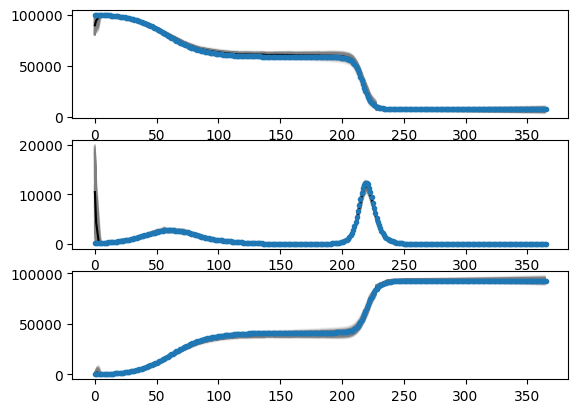

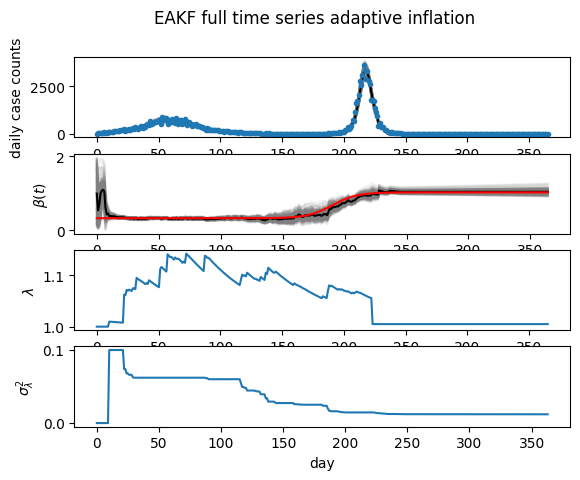

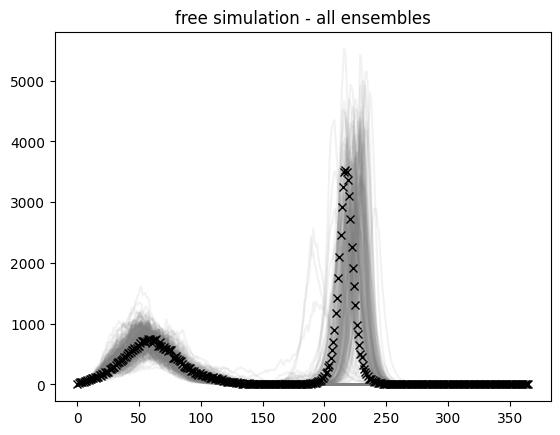

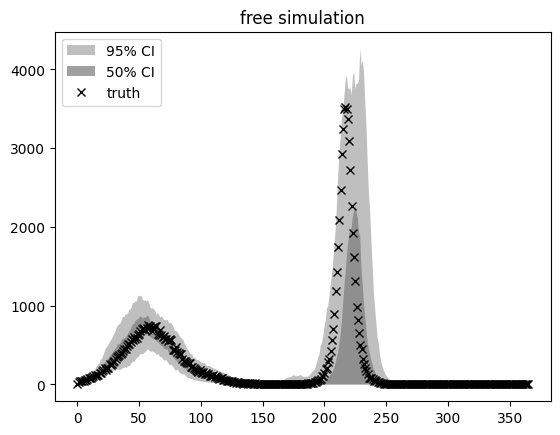

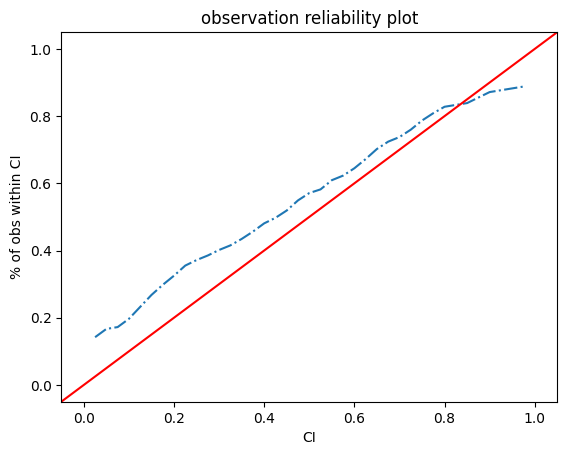

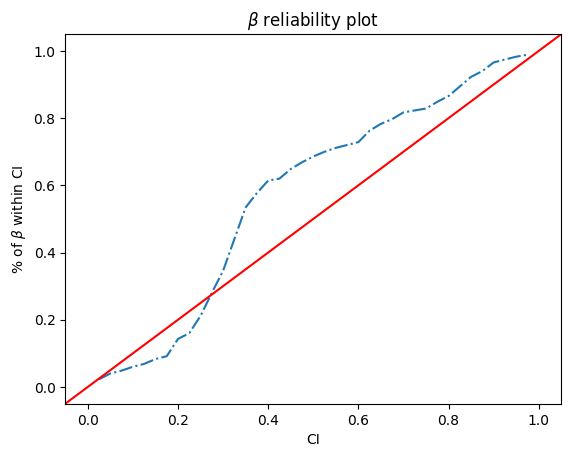

In [12]:
from epyfilter import eakf

kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)

from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}

kf.filter(prior)

kf.plot_posterior()
kf.plot_reliability()

In [13]:
from epyfilter import posterior_checks

posterior_checks.compute_ens_var(kf, 10)

0.002249684454486153

### Assess Posterior Distribution

1. Rerun simulating data using same parameters for ```num_real``` realizations to generate a discrete probability distribution for the data.
2. Compare with posterior predictive distribution (i.e., free simulation) using KL-divergence
$$
D_{\mathrm{KL}}(P \| Q)=\sum_{x \in \mathcal{X}} P(x) \log \left(\frac{P(x)}{Q(x)}\right)
$$
where $P$ is the data distribution and $Q$ is the posterior predictive distribution.

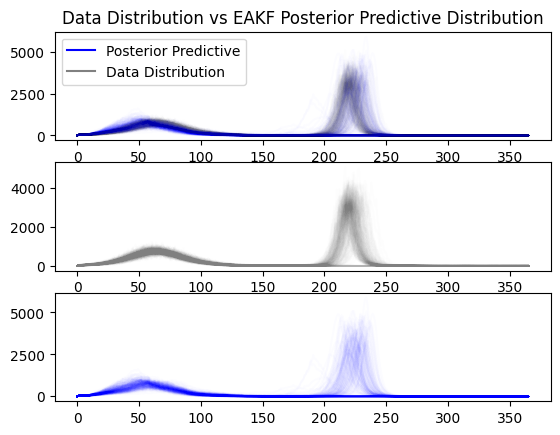

In [14]:
kf.plot_ppc()

In [15]:
from epyfilter import posterior_checks

In [16]:
print(posterior_checks.avg_wasserstein2(kf))
print(posterior_checks.avg_kl_divergence(kf))
posterior_checks.check_param_in_ci(kf, 200)

0.6069382562768537
0.5906282343630094


True

### No inflation

In [17]:
kf_no = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf_no.filter(prior, inf_method="none")

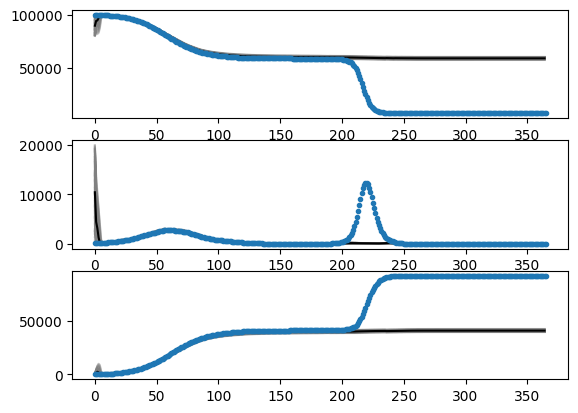

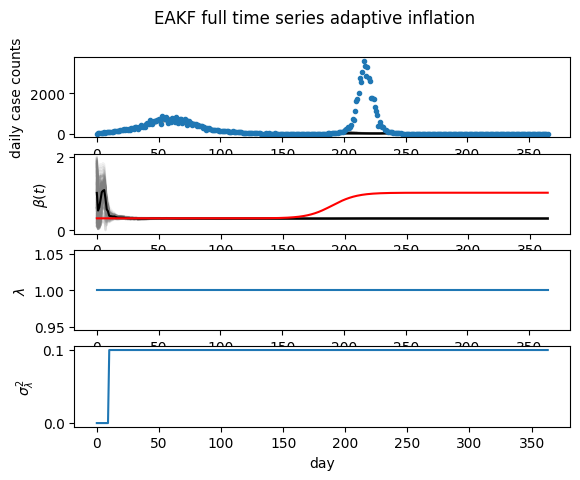

In [18]:
kf_no.plot_posterior()

Percent of observations in 95% CI 62.57%
Percent of observations in 50% CI 46.45%


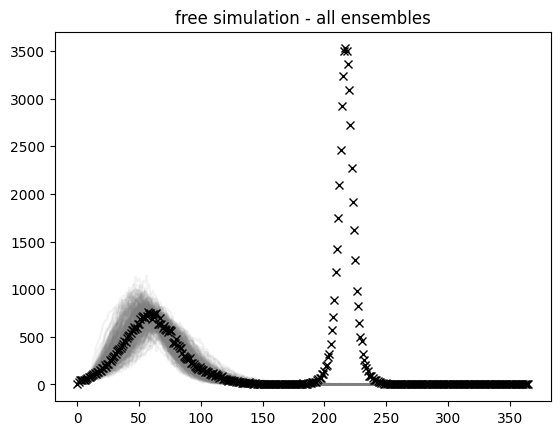

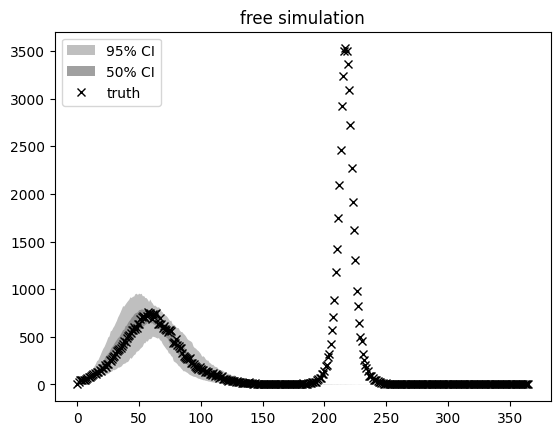

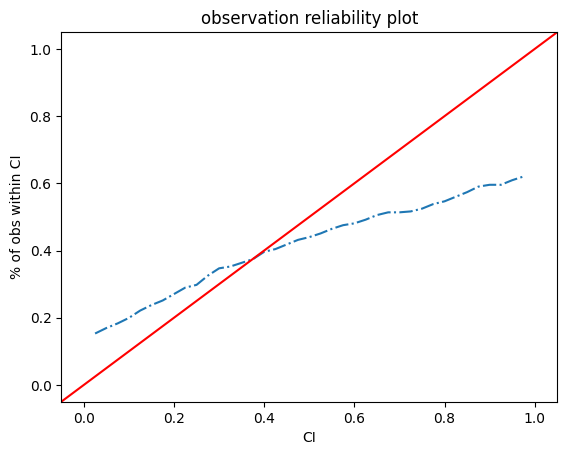

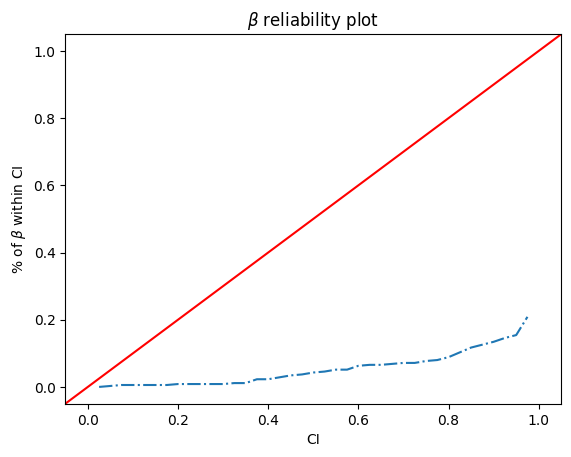

In [19]:
kf_no.plot_reliability()

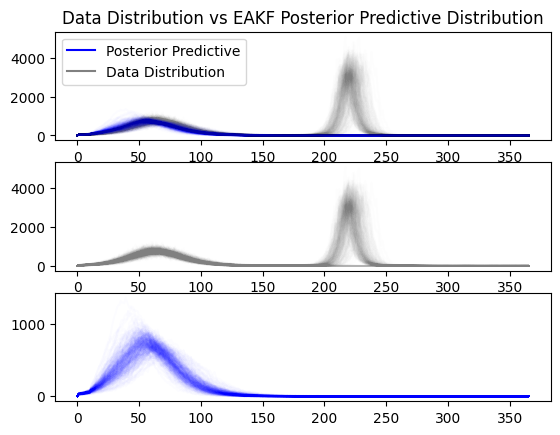

In [20]:
kf_no.plot_ppc()

In [21]:
print(posterior_checks.avg_wasserstein2(kf_no))
print(posterior_checks.avg_kl_divergence(kf_no))

0.7075319311068039
4.184243224668563


### Fixed inflation

In [22]:
kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)

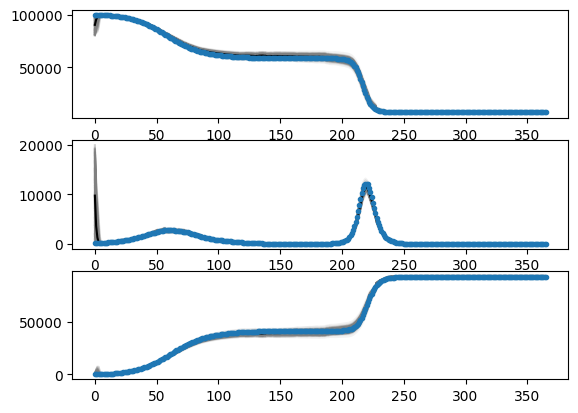

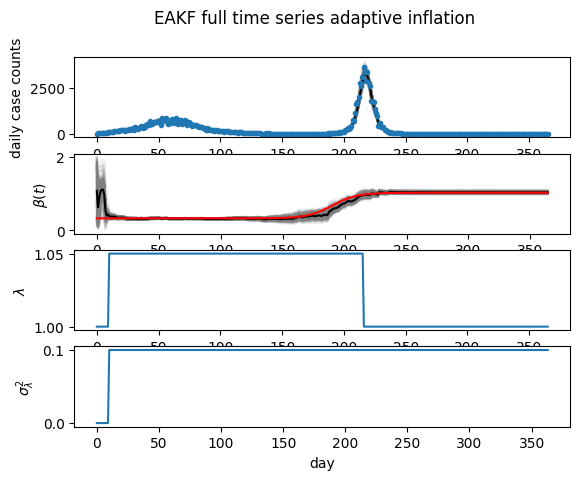

In [23]:
kf_fixed.plot_posterior()

Percent of observations in 95% CI 87.7%
Percent of observations in 50% CI 62.3%


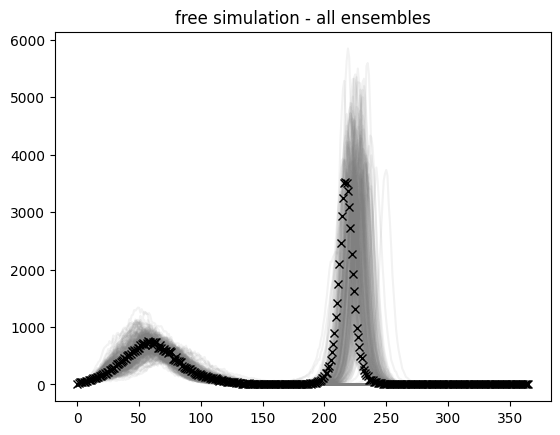

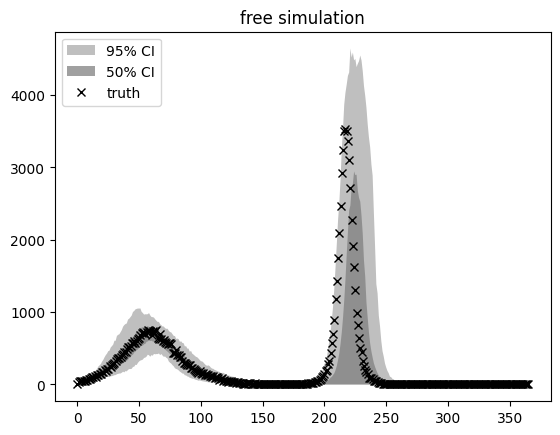

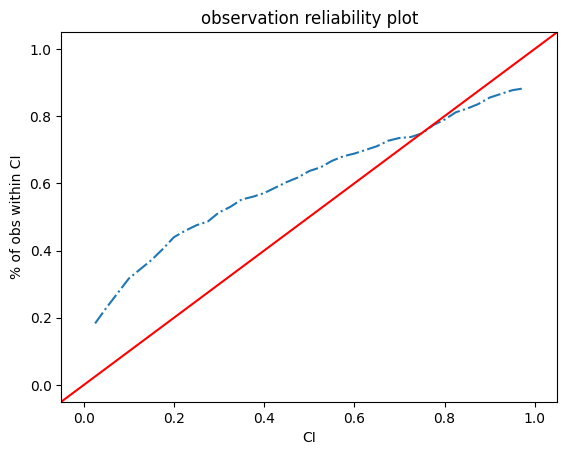

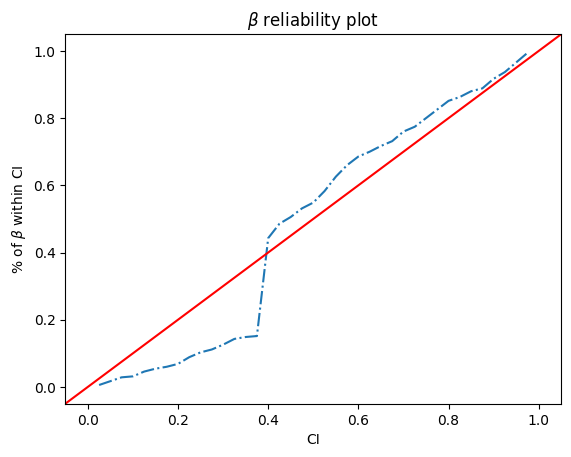

In [24]:
kf_fixed.plot_reliability()

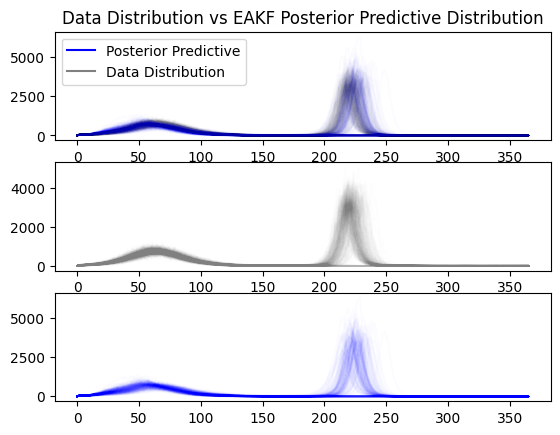

In [25]:
kf_fixed.plot_ppc()

In [26]:
print(posterior_checks.avg_wasserstein2(kf_fixed))
print(posterior_checks.avg_kl_divergence(kf_fixed))

0.4800317966873311
0.49469902446897646


# Adaptive Inflation with EnSRS

In [27]:
a = np.empty((0, 5))

b = np.array(["adaptive inflation", 1, 2, 3, 4])

np.vstack((a,b))

array([['adaptive inflation', '1', '2', '3', '4']], dtype='<U32')

In [28]:
from epyfilter import enks
from epyfilter import posterior_checks

ks = enks.EnsembleSquareRootSmoother(kf)

0.37061871558192266

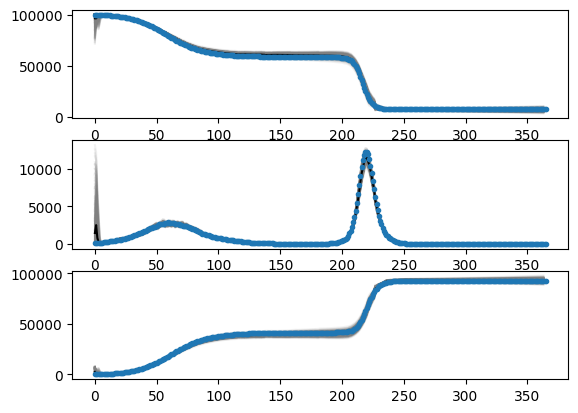

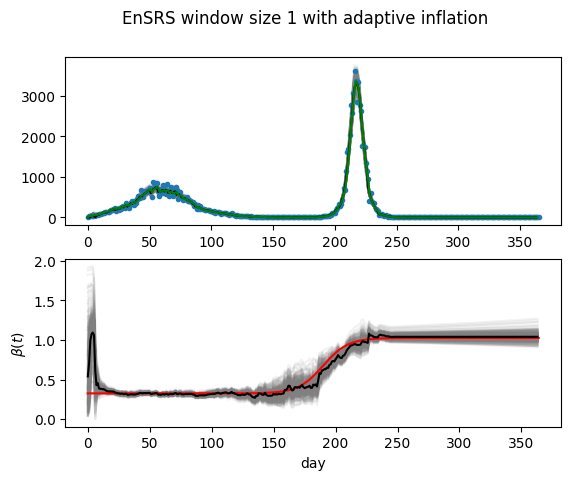

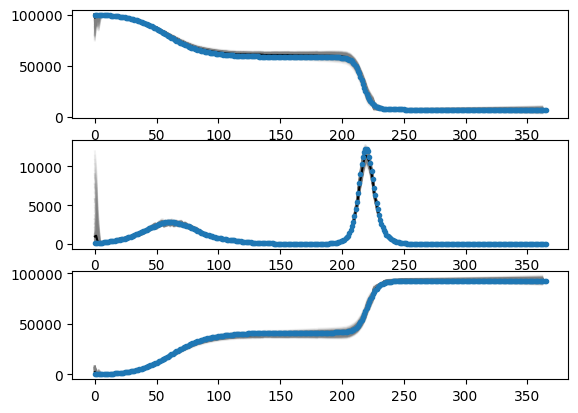

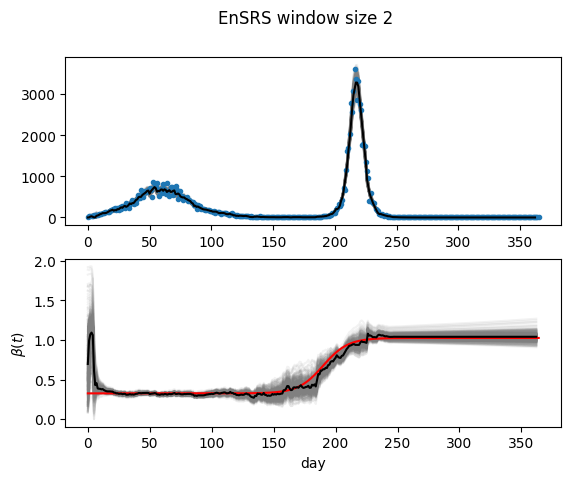

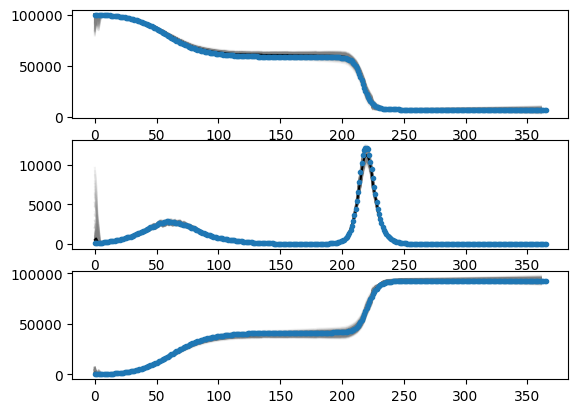

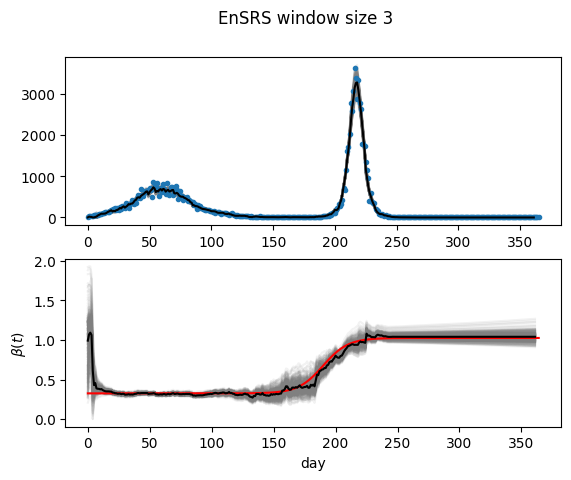

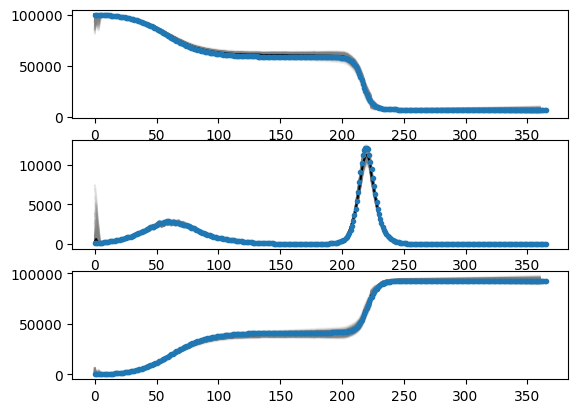

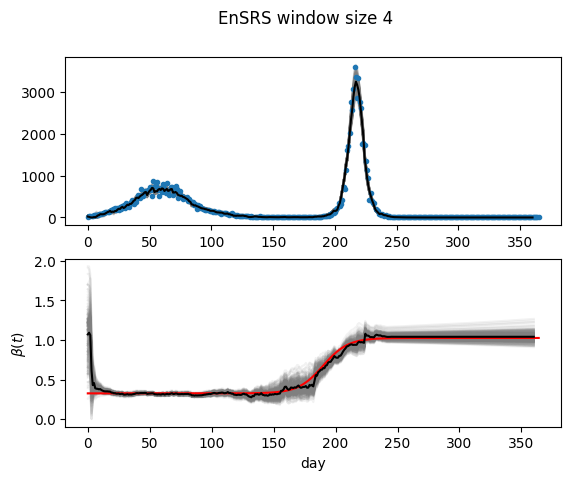

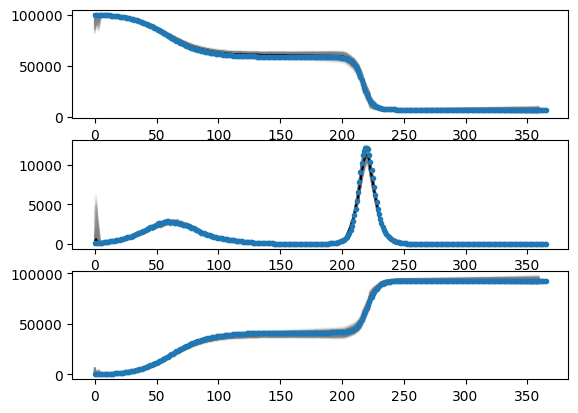

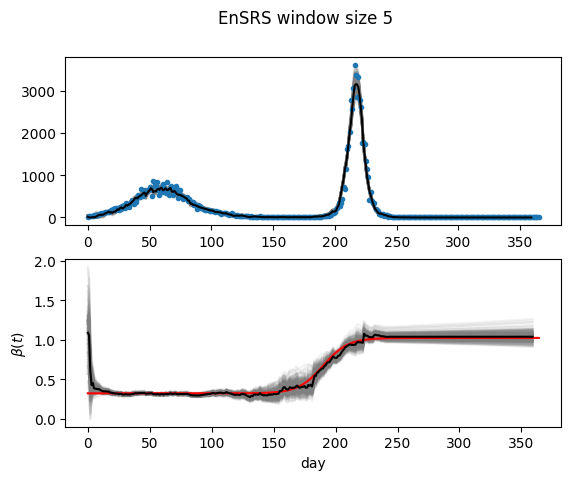

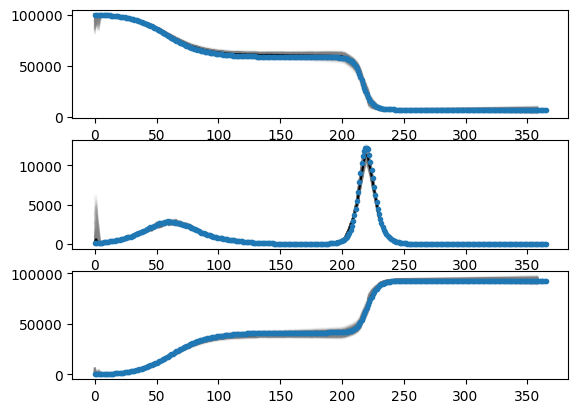

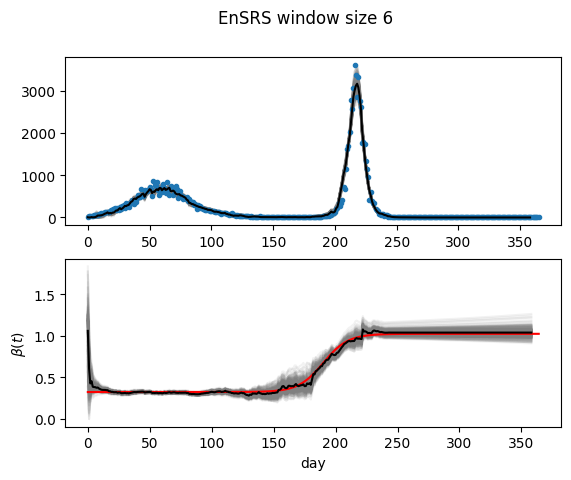

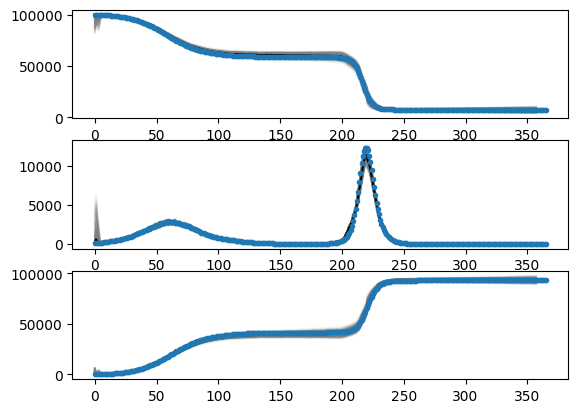

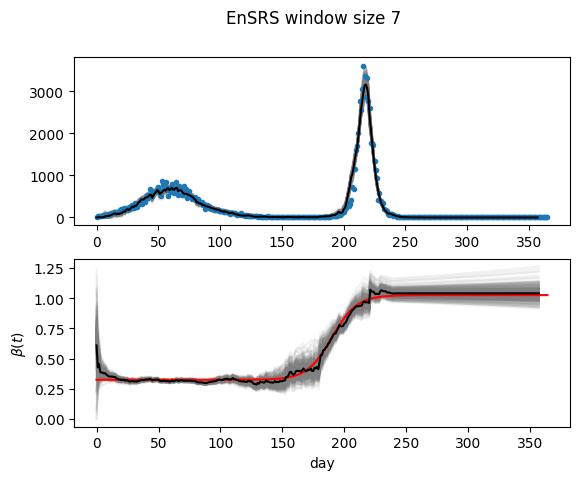

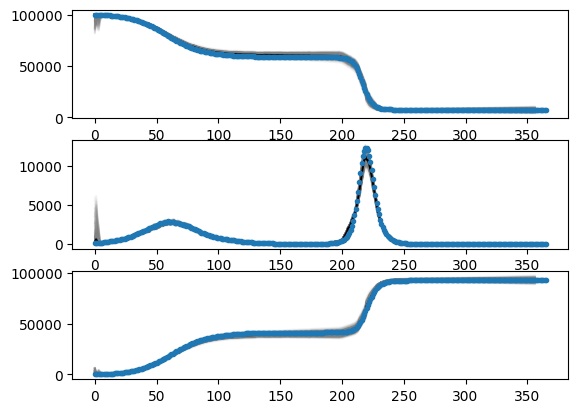

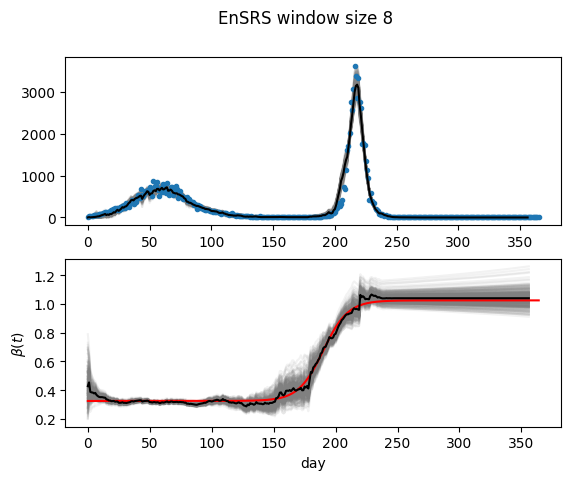

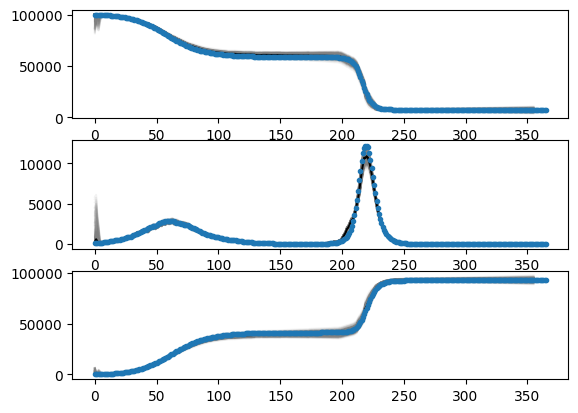

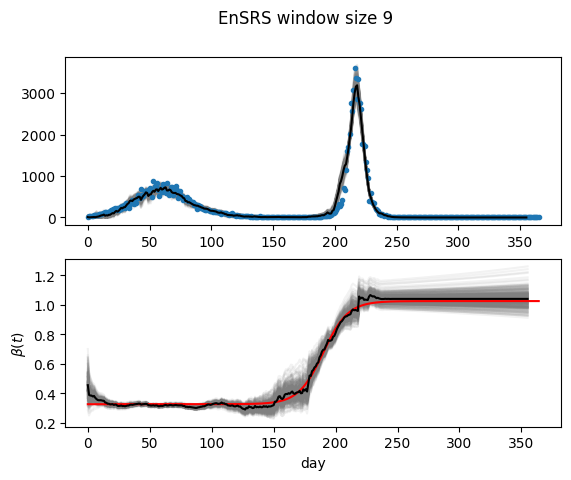

In [30]:
ks.smooth(window_size=10, plot=True)
posterior_checks.avg_wasserstein2_ks(ks)

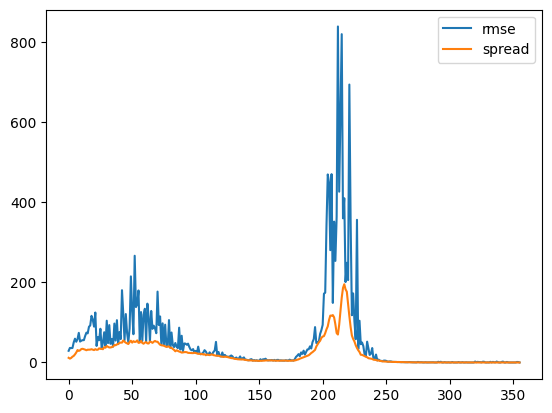

In [54]:
i_ks = np.array([x.i for x in ks.x_list])
rmse = np.sqrt(np.mean((i_ks.T - ks.data.i[1:len(i_ks)+1])**2, axis=0))
spread = np.sqrt(np.var(i_ks, axis=1))

plt.plot(rmse, label='rmse')
plt.plot(spread, label='spread')
plt.legend()

In [30]:
check_again_df = pd.read_csv("../src/epyfilter/c2b2/param_list.csv")

In [23]:
plot = False

import pandas as pd
import time

n_real = 100
n_ens = 300

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
    },
}

df_list = []

for i in range(100):
    rt0 = check_again_df.iloc[i]['rt_0']
    rt1 = check_again_df.iloc[i]['rt_1']
    m = check_again_df.iloc[i]['midpoint']
    k = check_again_df.iloc[i]['k']
    data = simulate_data.simulate_data(rt_0 = rt0, rt_1 = rt1, midpoint=m, k=k, n_t = 365, t_I = 4., N = 100_000, S0 = 99_900, I0 = 100, add_noise=True, noise_param=1/50)
    data.compute_data_distribution()
    model = model_da.SIR_model(data)
    
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    
    adaptive_kl = []
    adaptive_w2 = []
    adaptive_in_ci = []
    
    no_kl = []
    no_w2 = []
    no_in_ci = []
    
    fixed_kl = []
    fixed_w2 = []
    fixed_in_ci = []
    
    smooth_kl = []
    smooth_w2 = []
    smooth_in_ci = []

    for _ in range(n_real):

        kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
        kf.filter(prior)
        
        kf_no = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
        kf_no.filter(prior, inf_method="none")

        kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=300)
        kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)
        
        ks = enks.EnsembleSquareRootSmoother(kf)
        ks.smooth(window_size=10, plot=False)
        
        adaptive_w2.append(posterior_checks.avg_wasserstein2(kf))
        adaptive_kl.append(posterior_checks.avg_kl_divergence(kf))
        adaptive_in_ci.append(posterior_checks.check_param_in_ci(kf, late_day))
        
        no_w2.append(posterior_checks.avg_wasserstein2(kf_no))
        no_kl.append(posterior_checks.avg_kl_divergence(kf_no))
        no_in_ci.append(posterior_checks.check_param_in_ci(kf_no, late_day))
        
        fixed_w2.append(posterior_checks.avg_wasserstein2(kf_fixed))
        fixed_kl.append(posterior_checks.avg_kl_divergence(kf_fixed))
        fixed_in_ci.append(posterior_checks.check_param_in_ci(kf_fixed, late_day))
        
        smooth_w2.append(posterior_checks.avg_wasserstein2_ks(ks))
        smooth_kl.append(posterior_checks.avg_kl_divergence_ks(ks))
        smooth_in_ci.append(posterior_checks.check_param_in_ci_ks(ks, late_day))
    
    kl = [np.mean(no_kl), np.mean(fixed_kl), np.mean(adaptive_kl), np.mean(smooth_kl)]
    w2 = [np.mean(no_w2), np.mean(fixed_w2), np.mean(adaptive_w2), np.mean(smooth_w2)]
    in_ci = [np.mean(no_in_ci), np.mean(fixed_in_ci), np.mean(adaptive_in_ci), np.mean(smooth_in_ci)]
    param_df = pd.DataFrame(np.array([kl, w2, in_ci]).T, columns=['kl', 'w2', 'in_ci'])
    param_df['method'] = ['no inflation', 'fixed inflation', 'adaptive inflation', 'smooth']
    param_df['rt0'] = rt0
    param_df['rt1'] = rt1
    param_df['m'] = m
    param_df['k'] = k
    param_df['param_set'] = i
    df_list.append(param_df)

  1%|▊                                                                                    | 1/100 [03:57<6:32:02, 237.60s/it]


KeyboardInterrupt: 

In [24]:
df = pd.concat(df_list)
df

,kl,w2,in_ci,method,rt0,rt1,m,k,param_set
0,7.686946,1.010329,0.0,no inflation,1.3,2.0,94.0,0.8,0
1,1.969074,0.727068,0.0,fixed inflation,1.3,2.0,94.0,0.8,0
2,0.475671,0.475197,0.0,adaptive inflation,1.3,2.0,94.0,0.8,0
3,0.446792,0.261068,0.0,smooth,1.3,2.0,94.0,0.8,0


In [ ]:
# df.to_csv("compare_methods_0_100.csv", index=False)

In [25]:
df.groupby("method").mean().round(2)

,kl,w2,in_ci,rt0,rt1,m,k,param_set
method,,,,,,,,
adaptive inflation,0.48,0.48,0.0,1.3,2.0,94.0,0.8,0.0
fixed inflation,1.97,0.73,0.0,1.3,2.0,94.0,0.8,0.0
no inflation,7.69,1.01,0.0,1.3,2.0,94.0,0.8,0.0
smooth,0.45,0.26,0.0,1.3,2.0,94.0,0.8,0.0


In [ ]:
# from matplotlib.ticker import PercentFormatter

# plt.title(f"100 parameter scenarios with {n_real} realizations each")
# plt.ylabel("Percent")
# plt.xlabel(r"quantile of $\beta(t_1)$ posterior")
# _ = plt.hist(early_hist_list.flatten(), weights=np.ones(len(early_hist_list.flatten())) / len(early_hist_list.flatten()), range=(0,100), bins=100)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.show()

$$
t_1 = -\frac{1}{k} \log\left(\frac{\beta_1 - \beta_0}{1.01\beta_0 - \beta_0}-1\right) + m
$$

$$
t_2 = -\frac{1}{k} \log\left(\frac{\beta_1 - \beta_0}{0.99\beta_1 - \beta_0}-1\right) + m
$$

In [ ]:
# beta = data.construct_beta(data.rt, data.t_I)

# fig, ax = plt.subplots()
# ax.plot(beta)
# ax.plot(int(early_day), beta[int(early_day)], '.', color='red')
# ax.plot(int(late_day), beta[int(late_day)], '.', color='red')

In [ ]:
# plt.title(f"100 parameter scenarios with {n_real} realizations each")
# plt.ylabel("Percent")
# plt.xlabel(r"quantile of $\beta(t_2)$ posterior")
# _ = plt.hist(late_hist_list.flatten(), weights=np.ones(len(late_hist_list.flatten())) / len(late_hist_list.flatten()), range=(0,100), bins=100)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.show()

In [ ]:

# x_lag_list = np.array(x_lag_list)
# x_lag_means = np.mean(x_lag_list, axis=2)

# fig, ax = plt.subplots(3)
# ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
# ax[0].plot(x_lag_means[:,0], color='black')
# ax[0].plot(data.S, '.')

# ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
# ax[1].plot(x_lag_means[:,1], color='black')
# ax[1].plot(data.I, '.')

# ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
# ax[2].plot(x_lag_means[:,2], color='black')
# ax[2].plot(data.R, '.')

# fθ_lag_list = np.array(θ_lag_list)

# θ_lag_list = np.array(θ_lag_list)


# fig, ax = plt.subplots(2)

# ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
# ax[0].plot(data.i, '.')
# ax[0].plot(x_lag_means[:,3], color='black')
# # ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

# ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
# ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
# ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
# # ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
# ax[1].set_xlabel('day')
# ax[1].set_ylabel(r'$\beta(t)$')

# fig.suptitle(f'EnSRS window size {l} with adaptive inflation')

## RMSE vs Ensemble Spread

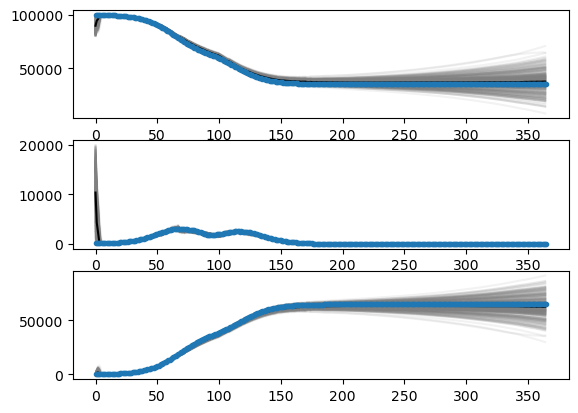

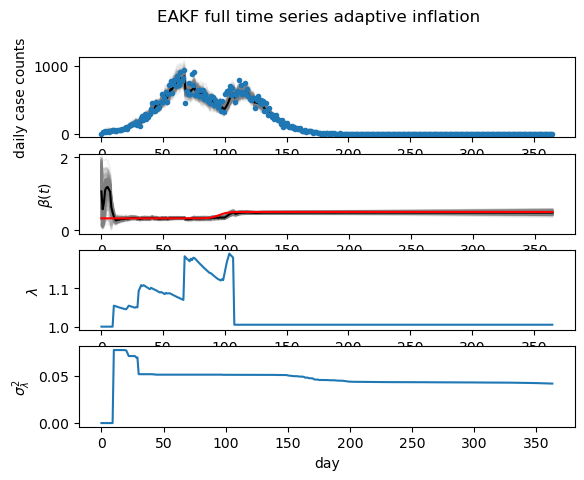

In [50]:
kf.plot_posterior()

In [64]:
i_kf = np.array([x.i for x in kf.x_list])
np.mean((np.mean(i_kf, axis=1) - kf.data.i[1:])**2)

3114.6707098429374

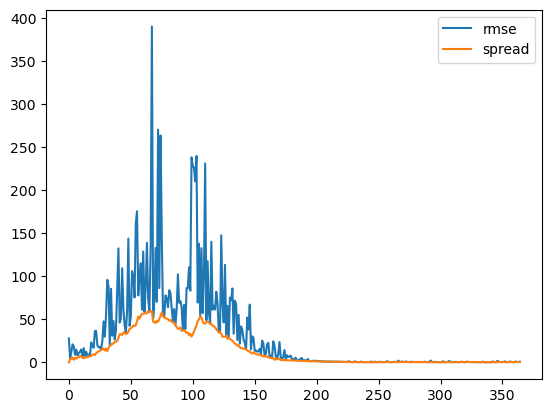

In [49]:
i_kf = np.array([x.i for x in kf.x_list])
rmse = np.sqrt(np.mean((i_kf.T - kf.data.i[1:])**2, axis=0))
spread = np.sqrt(np.var(i_kf, axis=1))

plt.plot(rmse, label='rmse')
plt.plot(spread, label='spread')
plt.legend()

# Archive

In [ ]:
# import collections

# SIR = collections.namedtuple(
#   typename='SIRComponents',
#   field_names=[
#     'S',              # S
#     'I',               # I
#     'R',                # R
#     'i'])

# ModelParams = collections.namedtuple(
#     typename='ModelParams',
#     field_names=[
#       'beta',                        # Beta
#       't_I'   # t_I = 1/gamma
#     ]
# )

# beta = data.construct_beta(data.rt, data.t_I)

# x = SIR(
#     S = data.S0,
#     I = data.I0,
#     R = 0,
#     i = 0
# )
# θ = ModelParams(beta, data.t_I)

# def f(t, x, θ, N, dt=1, noise_param=1/25):
#     """
#     State transition function.
#         Args:
#             t: time
#             x: state space
#             θ: parameters
#             N: population
#             dt: time step in days
#     """

#     # Stochastic transitions
#     dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
#     dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
#     # OEV = np.maximum(1., dSI**2 * noise_param)
#     # OEV_sample= np.random.normal(0, 1, size=len(dSI))
#     # i_noise = dSI + OEV_sample * np.sqrt(OEV)

#     # Updates
#     x_new = SIR(
#         S = np.clip(x.S - dSI, 0, N),
#         I = np.clip(x.I + dSI - dIR, 0, N),
#         R = np.clip(x.R + dIR, 0, N),
#         i = np.clip(dSI, 0, N)
#     )

#     return x_new

# def g(x):
#     """
#     Observational function.
#         Args:
#             x: state space
#             α: report rate
#     """
#     # y = np.random.binomial(x.i.astype(int), α)
#     return x.i

# def f0(pop, m=300):
#     """
#     Initial guess of the state space.
#         Args:
#             pop: population
#             m: number of ensemble members
#     """
# #     I0 = pop * inf_init
# #     S0 = pop - I0
# #     R0 = 0
# #     i = 0

#     S0 = np.random.uniform(pop*0.8, pop, size=m)
#     I0 = pop - S0
#     R0 = np.zeros(m)
#     i0 = np.zeros(m)
    
#     x0 = SIR(
#         S = S0,
#         I = I0,
#         R = R0,
#         i = i0
#     )
#     return x0

# def θ0(prior, m=300):
#     """
#     Initial guess of the parameter space.
#         Args:
#             prior: prior
#             m: number of ensemble members
#     """
#     beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
#     θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
#     return θ0

# def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.001):
#     # step 3b
#     sig2p = np.var(y)
#     ybarp = np.mean(y)
#     D = np.abs(ybarp - z) * z / 50

#     # step 3c
#     # r = np.cov(x, y)[0, 1]  # i
#     r = np.corrcoef(x,y)[0,1]  # i
#     lam0 = (1.0 + r * (np.sqrt(lambar_prior) - 1.0)) ** 2  # iii
#     theta = np.sqrt(lam0 * sig2p + oev)  # iv

#     # v/ Appendix A
#     lbar = 1.0 / (np.sqrt(2 * np.pi) * theta) * np.exp(-(D**2) / (2.0 * theta**2))
#     dthetadlam = (
#         sig2p
#         * r
#         * (1.0 - r + r * np.sqrt(lambar_prior))
#         / (2.0 * theta * np.sqrt(lambar_prior))
#     )
#     lprime = lbar * (D**2 / theta**2 - 1.0) / theta * dthetadlam

#     b = lbar / lprime - 2 * lambar_prior
#     c = lambar_prior**2 - siglam2 - lbar * lambar_prior / lprime

#     lam1 = np.abs((-b + np.sqrt(b**2 - 4.0 * c)) / 2)
#     lam2 = np.abs((-b - np.sqrt(b**2 - 4.0 * c)) / 2)

#     if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
#         return lam1
#     else:
#         return lam2


# def _inflate_ensembles(ens, inflation_value, params=False):
#     if params:
#         _, m = np.asarray(ens).shape
#         ens_mean = np.mean(ens, 1, keepdims=True)
#         ens_inflated = ens_mean * np.ones((1, m)) + inflation_value * (
#             ens - ens_mean * np.ones((1, m))
#         )
#     else:
#         m = len(ens)
#         ens_mean = np.mean(ens)
#         ens_inflated = ens_mean * np.ones(m) + inflation_value * (
#             ens - ens_mean * np.ones(m)
#         )

#     return ens_inflated

# 

# def reprobe(x, prior, m):
#     """
#     Reprobe ensemble
#         Args:
#             x (nd.array) : ensemble
#             prior (dict) : prior 
#             m (int)      : number of ensemble members to reprobe
#     """
    
#     return x_probed

# def eakf(x, y, z, oev, m=3000):
#     """
#     Args:
#         x: latenet state rv or latent parameter rv
#         y: observed rv
#         z: observation
#         oev: observational error variance
#     """
#     x = np.array(x)
#     y = np.array(y)
    
#     p, m = x.shape

#     mu_prior  = y.mean()
#     var_prior = y.var()

#     # degenerate prior.
#     var_prior = np.where(var_prior == 0., 1e-3, var_prior)

#     var_post = var_prior * oev / (var_prior + oev)
#     mu_post  = var_post  * (mu_prior/var_prior + z/oev)
#     alpha    = (oev / (oev + var_prior)) ** (0.5)
#     dy       = (mu_post - y) + alpha * (y - mu_prior)
    
#     # compute covariance
#     rr = np.full((p, 1), np.nan)

#     # import pdb; pdb.set_trace()
#     for ip in range(p):
#         A  = np.cov(x[ip, :], y)
#         rr[ip,:] =  A[1, 0] / var_prior
#     dx = np.dot(rr, dy.reshape((1,m)))
#     # rr = np.cov(x, y)[:-1,-1] / var_prior
#     # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

#     xpost = x + dx
#     ypost = y + dy

#     return xpost, ypost, alpha

# from tqdm import tqdm

# x_list = []
# θ_list = []
# lam_list = []
# alpha_list = []

# m = 300
# turn_off = False

# lam = lam_S = lam_I = lam_R = lam_i = 1.01

# for t, date in enumerate(range(data.n_t)):
#     if t == 0:
#         x = f0(data.N, m=m)
#         θ = θ0(prior, m=m)
#     else:
#         x = f(t, x, θ, data.N)  # prediction
#         y = g(x)           # analysis
#         z = data.i[t]
        
#         oev = np.maximum(10, z**2/50)
#         if t > 50:
#             lam = _adaptive_inflation(θ.beta, y, z, oev, lambar_prior=lam)
#             lam_S = _adaptive_inflation(x.S, y, z, oev)
#             lam_I = _adaptive_inflation(x.I, y, z, oev)
#             lam_R = _adaptive_inflation(x.R, y, z, oev)
#             lam_i = _adaptive_inflation(x.i, y, z, oev)
#             # if z > 0:
#             #     if np.abs(np.mean(y) - z) / z > 1:
#             #         turn_off = True
#             #         lam = 1.
#             #         lam_S = 1.
#             #         lam_I = 1.
#             #         lam_R = 1.
#             #         lam_i = 1.
#             if np.isnan(lam):
#                 lam = 1.
#             if np.isnan(lam_S):
#                 lam_S = 1.
#             if np.isnan(lam_I):
#                 lam_I = 1.
#             if np.isnan(lam_R):
#                 lam_R = 1.
#             if np.isnan(lam_i):
#                 lam_i = 1.
#             # if turn_off:
#             #     lam = 1.
#             #     lam_S = 1.
#             #     lam_I = 1.
#             #     lam_R = 1.
#             #     lam_i = 1.
#             lam_list.append(lam)
#             θ = _inflate_ensembles(θ, inflation_value=lam, params=True)
#             θ = np.clip(θ, 0, 10)
#             # print(lam)
#             θ = ModelParams(*θ)
        
#             # print(lam_S, lam_I, lam_R)
#             S = _inflate_ensembles(x.S, inflation_value=lam_S)
#             I = _inflate_ensembles(x.I, inflation_value=lam_I)
#             R = _inflate_ensembles(x.R, inflation_value=lam_R)
#             i = _inflate_ensembles(x.i, inflation_value=lam_i)

#             x = SIR(
#                 S = np.clip(S, 0, data.N),
#                 I = np.clip(I, 0, data.N),
#                 R = np.clip(R, 0, data.N),
#                 i = np.clip(i, 0, data.N)
#             )
        
#         x, new_i, alpha = eakf(x, y, z, oev=oev)
#         x = SIR(*x)
#         x = x._replace(i=new_i)
#         x = SIR(
#             S = np.clip(x.S, 0, data.N),
#             I = np.clip(x.I, 0, data.N),
#             R = np.clip(x.R, 0, data.N),
#             i = np.clip(x.i, 0, data.N)
#         )
#         θ, _, alpha_θ = eakf(θ, y, z, oev=oev, m=m)
#         θ = np.clip(θ, 0, None)
#         θ = ModelParams(*θ)
        
#         alpha_list.append([alpha, alpha_θ])
    
#     x_list.append(x)
#     θ_list.append(θ)


# fig, ax = plt.subplots(3)
# ax[0].plot([x.S for x in x_list], color='gray', alpha=0.1)
# ax[0].plot(np.mean([x.S for x in x_list], axis=1), color='black')
# ax[0].plot(data.S, '.')

# ax[1].plot([x.I for x in x_list], color='gray', alpha=0.1)
# ax[1].plot(np.mean([x.I for x in x_list], axis=1), color='black')
# ax[1].plot(data.I, '.')

# ax[2].plot([x.R for x in x_list], color='gray', alpha=0.1)
# ax[2].plot(np.mean([x.R for x in x_list], axis=1), color='black')
# ax[2].plot(data.R, '.')

# fig, ax = plt.subplots(3)
# ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
# ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
# ax[0].plot(data.i, '.')
# ax[0].set_ylabel('daily case counts')

# ax[1].plot([θ.beta for θ in θ_list], color="gray", alpha=0.1)
# ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
# ax[1].plot(beta, color="red")
# ax[1].set_xlabel('day')
# ax[1].set_ylabel(r'$\beta(t)$')

# ax[2].plot(np.linspace(0,365,364), np.append(np.ones(50), lam_list))
# ax[2].set_xlabel("day")
# ax[2].set_ylabel(r"$\lambda$")

# # fig.suptitle('EAKF full time series adaptive inflation, "truncated prior"')
# fig.suptitle('EAKF full time series adaptive inflation')

# Infer Sigmoid Parameters

In [59]:
SigmoidModelParams = collections.namedtuple(
    typename='SigmoidModelParams',
    field_names=[
        'beta_0',
        'beta_1',
        'midpoint',
        'k'
    ]
)

def clip_sigmoid_params(θ):
    return SigmoidModelParams(
        beta_0 = np.clip(θ.beta_0, 0, None),
        beta_1 = np.clip(θ.beta_1, 0, None),
        midpoint = np.clip(θ.midpoint, 0, 365),
        k = np.clip(θ.k, 0, None),
    )

def clip_states(x):
    return SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )

prior = {
    'beta_0':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    'beta_1':{
        'dist': uniform,
        'args':{
            'low': 0.5,
            'high': 2.5,
        }
    },
    'midpoint':{
        'dist': uniform,
        'args':{
            'low': 30,
            'high': 200,
        }
    },
    'k':{
        'dist': uniform,
        'args':{
            'low': 0.01,
            'high': 2.,
        }
    },
    'logk':{
        'dist': uniform,
        'args':{
            'low':-2,
            'high':0.3,
        }
    }
}

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta_0 = prior['beta_0']['dist'](**prior['beta_0']['args'], size=m)
    beta_1 = prior['beta_1']['dist'](**prior['beta_1']['args'], size=m)
    k = prior['k']['dist'](**prior['k']['args'], size=m)
    midpoint = prior['midpoint']['dist'](**prior['midpoint']['args'], size=m)
    
    θ0 = SigmoidModelParams(
        beta_0 = beta_0,
        beta_1 = beta_1,
        midpoint = midpoint,
        k = k,
    )
    return θ0

def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
    dSI = np.random.poisson(x.S * x.I/ N * beta) # susceptible to infected
    dIR = np.random.poisson(x.I / data.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

In [60]:
x_list = []
xhat_list = []
θ_list = []
for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
        xhat_list.append(x)
    else:
        x = f(t, x, θ, data.N)  # prediction
        xhat_list.append(x)
        y = g(x)           # analysis
        z = data.i[t]
        if t > 50:
            lam_b0 = _adaptive_inflation(θ.beta_0, y, z, oev)
            lam_b1 = _adaptive_inflation(θ.beta_1, y, z, oev)
            lam_m = _adaptive_inflation(θ.midpoint, y, z, oev)
            lam_k = _adaptive_inflation(θ.k, y, z, oev)
            lam_S = _adaptive_inflation(x.S, y, z, oev)
            lam_I = _adaptive_inflation(x.I, y, z, oev)
            lam_R = _adaptive_inflation(x.R, y, z, oev)
            lam_i = _adaptive_inflation(x.i, y, z, oev)
            if np.isnan(lam_b0):
                lam_b0 = 1.
            if np.isnan(lam_b1):
                lam_b1 = 1.
            if np.isnan(lam_m):
                lam_m = 1.
            if np.isnan(lam_k):
                lam_k = 1.
            if np.isnan(lam_S):
                lam_S = 1.
            if np.isnan(lam_I):
                lam_I = 1.
            if np.isnan(lam_R):
                lam_R = 1.
            if np.isnan(lam_i):
                lam_i = 1.
            
            b0 = _inflate_ensembles(θ.beta_0, inflation_value=lam_b0)
            b1 = _inflate_ensembles(θ.beta_1, inflation_value=lam_b1)
            m = _inflate_ensembles(θ.midpoint, inflation_value=lam_m)
            k = _inflate_ensembles(θ.k, inflation_value=lam_k)
            
            θ = SigmoidModelParams(
                beta_0 = b0,
                beta_1 = b1,
                midpoint = m,
                k = k,
            )

            # print(lam_S, lam_I, lam_R)
            S = _inflate_ensembles(x.S, inflation_value=lam_S)
            I = _inflate_ensembles(x.I, inflation_value=lam_I)
            R = _inflate_ensembles(x.R, inflation_value=lam_R)
            i = _inflate_ensembles(x.i, inflation_value=lam_i)

            x = SIR(
                S = np.clip(S, 0, data.N),
                I = np.clip(I, 0, data.N),
                R = np.clip(R, 0, data.N),
                i = np.clip(i, 0, data.N)
            )
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        oev = np.maximum(10, z**2/50)
        x, new_i, alpha = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = clip_states(x)
        x = x._replace(i=new_i)
        θ, _, alpha = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = SigmoidModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1187024659.py:97: RuntimeWarning: overflow encountered in exp
  beta = θ.beta_0 + (θ.beta_1 - θ.beta_0) / (1 + np.exp(-θ.k*(t - θ.midpoint)))
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:40: RuntimeWarning: invalid value encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:41: RuntimeWarning: invalid value encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  b = lbar/lprime - 2*lambar_prior
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_49340/1622220394.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
/var/folders/zn/k_h7_jyn53z

Text(0, 0.5, '$\\beta(t)$')

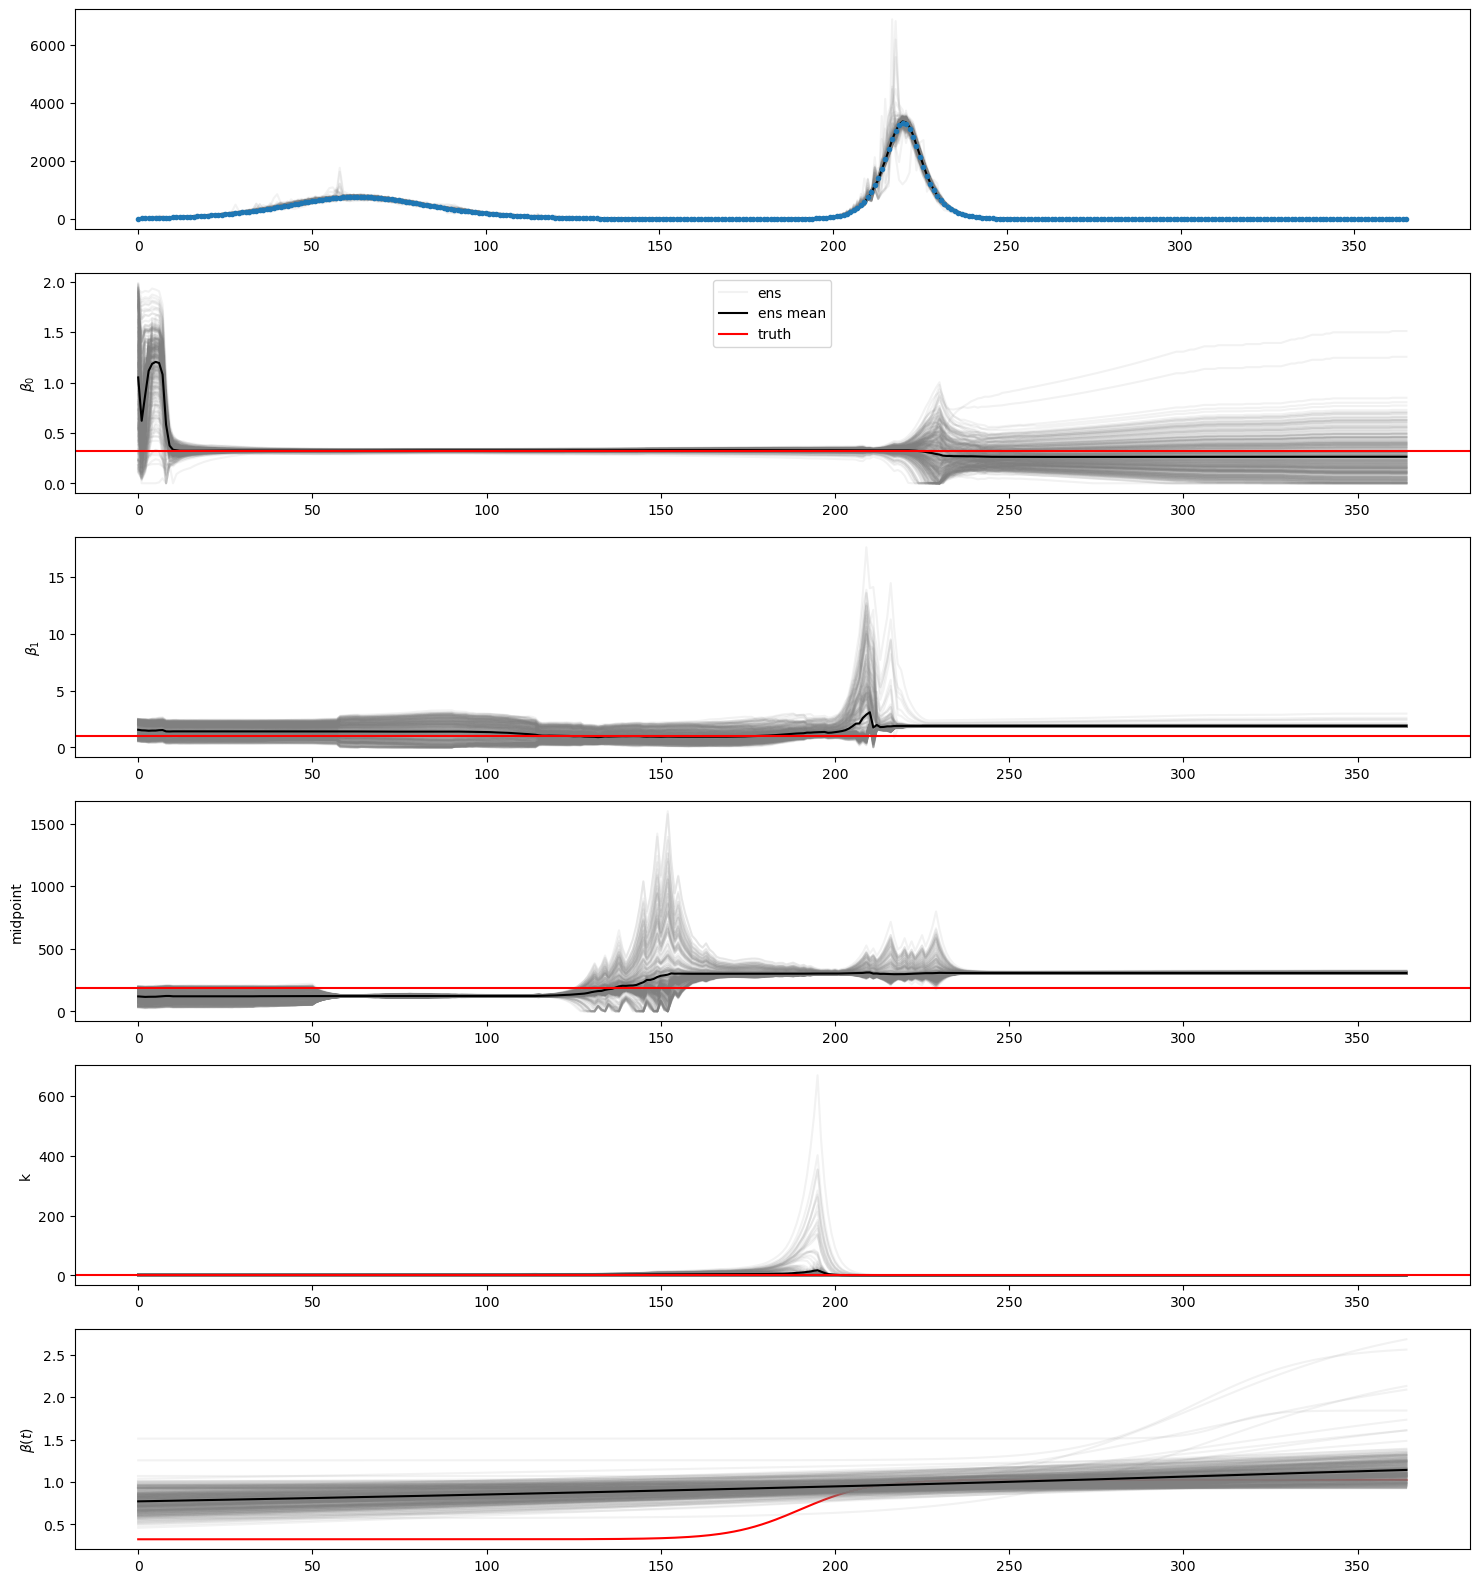

In [61]:
post = θ_list[-1]
t = np.arange(0, data.n_t)
sigmoid = [post.beta_0 + (post.beta_1 - post.beta_0) / (1 + np.exp(-post.k*(tt - post.midpoint))) for tt in t]

fig, ax = plt.subplots(6, figsize=(18,20))
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')

ax[1].plot([θ.beta_0 for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot([],[], 'gray', alpha=0.1, label='ens')
ax[1].plot(np.mean([θ.beta_0 for θ in θ_list], axis=1), color='black', label="ens mean")
ax[1].axhline(beta[0], color="red", label="truth")
ax[1].set_ylabel(r"$\beta_0$")
ax[1].legend()

ax[2].plot([θ.beta_1 for θ in θ_list], color="gray", alpha=0.1)
ax[2].plot(np.mean([θ.beta_1 for θ in θ_list], axis=1), color='black')
ax[2].axhline(beta[-1], color="red")
ax[2].set_ylabel(r"$\beta_1$")

ax[3].plot([θ.midpoint for θ in θ_list], color="gray", alpha=0.1)
ax[3].plot(np.mean([θ.midpoint for θ in θ_list], axis=1), color='black')
ax[3].axhline(data.midpoint, color="red")
ax[3].set_ylabel(r"midpoint")

ax[4].plot([θ.k for θ in θ_list], color="gray", alpha=0.1)
ax[4].plot(np.mean([θ.k for θ in θ_list], axis=1), color='black')
ax[4].axhline(data.k, color="red")
ax[4].set_ylabel(r"k")

ax[5].plot(beta, color="red")
ax[5].plot(sigmoid, color="gray", alpha=0.1)
ax[5].plot(np.mean(sigmoid, axis=1), color="black")
ax[5].set_ylabel(r"$\beta(t)$")



In [56]:
l = 1

x_list = np.array(x_list)
xhat_list = np.array(xhat_list)
θ_list = np.array(θ_list)

x_lag_list = []
θ_lag_list = []

for k in range(data.n_t-1):
    z = data.i[k+l]
    oev = np.maximum(10, z**2/50)
    H = np.array([0,0,0,1])

    ## Smooth STATES
    x = x_list[k,:,:]
    xhat = xhat_list[k+l,:,:]
        
    y = H@xhat
    ybar_hat = np.mean(y)
    Pyy = np.cov(y)
    Pb = np.cov(xhat)
    Pba = np.cov(x, xhat)[4:,4:]
    # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    
    x_bar = np.mean(x, axis=1)
    xhat_bar = np.array([np.mean(xhat, axis=1)])
    # eq 8
    xbar_lag = x_bar + K_lag*(z - ybar_hat)
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)
    
    x_lag = np.clip(x_lag, 0, data.N)
    x_lag = SIR(*x_lag)
    x_lag_list.append(x_lag)
    
    
    ## Smooth PARAMS
    θ = θ_list[k,:,:]
    Pb = np.cov(θ,y)
    H = np.array([0,0,1])
    Pba = np.cov(θ,y)
    
    # eq 9
    K_lag = (H@Pba).T/(Pyy+oev)
    K_lag = K_lag[:-1]
    
    θ_bar = np.array([np.mean(θ, axis=1)]).T
    θhat_bar = θ_bar
    # eq 8
    θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
    # eq 15
    Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
    # eq 13
    θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])
    
    θ_lag = np.clip(θ_lag, 0, 10)
    θ_lag = ModelParams(*θ_lag)
    θ_lag_list.append(θ_lag)
    
# plot
x_lag_list = np.array(x_lag_list)
x_lag_means = np.mean(x_lag_list, axis=2)

fig, ax = plt.subplots(3)
ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
ax[0].plot(x_lag_means[:,0], color='black')
ax[0].plot(data.S, '.')

ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
ax[1].plot(x_lag_means[:,1], color='black')
ax[1].plot(data.I, '.')

ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
ax[2].plot(x_lag_means[:,2], color='black')
ax[2].plot(data.R, '.')

fθ_lag_list = np.array(θ_lag_list)

θ_lag_list = np.array(θ_lag_list)

fig, ax = plt.subplots(2)

ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
ax[0].plot(data.i, '.')
ax[0].plot(x_lag_means[:,3], color='black')
ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
# ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle(f'EnSRS window size {l} with adaptive inflation')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

In [ ]:
for l in np.arange(2,10):
    print(l)
    
    θ_list = np.array(θ_lag_list).copy()
    x_list = np.array(x_lag_list).copy()
    
    x_lag_list = []
    θ_lag_list = []

    for k in range(data.n_t-l):
        z = data.i[k+l]
        oev = np.maximum(10, z**2/50)
        H = np.array([0,0,0,1])

        ## Smooth STATES
        x = x_list[k,:,:]
        xhat = xhat_list[k+l,:,:]

        y = H@xhat
        ybar_hat = np.mean(y)
        Pyy = np.cov(y)
        Pb = np.cov(xhat)
        Pba = np.cov(x, xhat)[4:,4:]
        # Pba = (x - np.array([x_bar]).T)@(H@(xhat - np.array([xhat_bar]).T)).T
        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)

        x_bar = np.mean(x, axis=1)
        xhat_bar = np.array([np.mean(xhat, axis=1)])
        # eq 8
        xbar_lag = x_bar + K_lag*(z - ybar_hat)
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        x_lag = (x - np.array([x_bar]).T) + np.array([xbar_lag]).T - Ktilde_lag*H@(xhat - xhat_bar.T)

        x_lag = np.clip(x_lag, 0, data.N)
        x_lag = SIR(*x_lag)
        x_lag_list.append(x_lag)


        ## Smooth PARAMS
        θ = θ_list[k,:,:]
        Pb = np.cov(θ,y)
        H = np.array([0,0,1])
        Pba = np.cov(θ,y)

        # eq 9
        K_lag = (H@Pba).T/(Pyy+oev)
        K_lag = K_lag[:-1]

        θ_bar = np.array([np.mean(θ, axis=1)]).T
        θhat_bar = θ_bar
        # eq 8
        θ_bar_lag = θ_bar + np.array([K_lag*(z - ybar_hat)]).T
        # eq 15
        Ktilde_lag = K_lag/(1. + np.sqrt(oev/(Pyy + oev)))
        # eq 13
        θ_lag = (θ - θ_bar) + θ_bar_lag - np.array([Ktilde_lag]).T@np.array([y - ybar_hat.T])

        θ_lag = np.clip(θ_lag, 0, 10)
        θ_lag = ModelParams(*θ_lag)
        θ_lag_list.append(θ_lag)
    
    # plot
    x_lag_list = np.array(x_lag_list)
    x_lag_means = np.mean(x_lag_list, axis=2)

    fig, ax = plt.subplots(3)
    ax[0].plot(x_lag_list[:,0,:], color='gray', alpha=0.1)
    ax[0].plot(x_lag_means[:,0], color='black')
    ax[0].plot(data.S, '.')

    ax[1].plot(x_lag_list[:,1,:], color='gray', alpha=0.1)
    ax[1].plot(x_lag_means[:,1], color='black')
    ax[1].plot(data.I, '.')

    ax[2].plot(x_lag_list[:,2,:], color='gray', alpha=0.1)
    ax[2].plot(x_lag_means[:,2], color='black')
    ax[2].plot(data.R, '.')

    fθ_lag_list = np.array(θ_lag_list)

    θ_lag_list = np.array(θ_lag_list)

    fig, ax = plt.subplots(2)

    ax[0].plot(x_lag_list[:,3,:], color='gray', alpha=0.1)
    ax[0].plot(data.i, '.')
    ax[0].plot(x_lag_means[:,3], color='black')
    # ax[0].plot(np.mean(x_list[:,3,:], axis=1), color='green')

    ax[1].plot(θ_lag_list[:,0,:], color="gray", alpha=0.1)
    ax[1].plot(data.construct_beta(data.rt, data.t_I), color="red")
    ax[1].plot(np.mean(θ_lag_list[:,0,:], axis=1), color="black")
    # ax[1].plot(np.mean(θ_list[:,0,:], axis=1)[:-1], color="green")
    ax[1].set_xlabel('day')
    ax[1].set_ylabel(r'$\beta(t)$')

    fig.suptitle(f'EnSRS window size {l} with adaptive inflation')
